In [1]:
# Importing all required libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
#Importing Dataset

df_main = pd.read_csv("./data/HRDataset_v14.csv")
#Making a set of colums from dataset which are categorical, not numerical
categorical = set(('Employee_Name','Position', 'State', 'Zip', 'DOB', 'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'DateofHire', 'DateofTermination','TermReason' ,'EmploymentStatus', 'Department', 'ManagerName', 'RecruitmentSource', 'PerformanceScore', 'LastPerformanceReview_Date' ))


group_columns = ['EmpID', 'Salary']
sensitive_column = 'Employee_Name'
df_main.head()


,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,...,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,...,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,...,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,...,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,1/3/2019,0,15
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,...,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,2/1/2016,0,2


In [3]:
#Removing outliers
df_main.drop(df_main[df_main['Salary'] >= 125000].index, inplace = True)


In [4]:
# Hits Spam ✌️
class Graph:
    def __init__(self):
        self.nodes = []

    def contains(self, name):
        for node in self.nodes:
            if(node.name == name):
                return True
        return False
    
    def find(self, name):
        if(not self.contains(name)):
            new_node = Node(name)
            self.nodes.append(new_node)
            return new_node
        else:
            return next(node for node in self.nodes if node.name == name)

    def add_edge(self, parent, child):
        parent_node = self.find(parent)
        child_node = self.find(child)

        parent_node.link_child(child_node)
        child_node.link_parent(parent_node)

    def sort_nodes(self):
        self.nodes.sort(key=lambda node: int(node.name))

    def normalize_auth_hub(self):
        auth_sum = sum(node.auth for node in self.nodes)
        hub_sum = sum(node.hub for node in self.nodes)

        for node in self.nodes:
            node.auth /= auth_sum
            node.hub /= hub_sum

    def get_auth_hub_list(self):
        auth_list = np.asarray([node.auth for node in self.nodes], dtype='float32')
        hub_list = np.asarray([node.hub for node in self.nodes], dtype='float32')

        return np.round(auth_list, 3), np.round(hub_list, 3)


class Node:
    def __init__(self, name):
        self.name = name
        self.children = []
        self.parents = []
        self.auth = 1.0
        self.hub = 1.0
        self.pagerank = 1.0

    def link_child(self, new_child):
        for child in self.children:
            if(child.name == new_child.name):
                return None
        self.children.append(new_child)

    def link_parent(self, new_parent):
        for parent in self.parents:
            if(parent.name == new_parent.name):
                return None
        self.parents.append(new_parent)

    def update_auth(self):
        self.auth = sum(node.hub for node in self.parents)

    def update_hub(self):
        self.hub = sum(node.auth for node in self.children)
            
            
def HITS_one_iter(graph):
    node_list = graph.nodes

    for node in node_list:
        node.update_auth()

    for node in node_list:
        node.update_hub()

    graph.normalize_auth_hub()


def HITS(graph, iteration=100):
    for i in range(iteration):
        HITS_one_iter(graph)

In [5]:
#Actually applying hits to get hub/authority scores
def init_graph(fname):
    with open(fname) as f:
        lines = f.readlines()

    graph = Graph()

    for line in lines:
        [parent, child] = line.strip().split(',')
        graph.add_edge(parent, child)

    graph.sort_nodes()

    return graph
    
    
graph = init_graph('./data/votes.txt')


HITS(graph, 7)
auth_list, hub_list = graph.get_auth_hub_list()
# print(auth_list)
# print(hub_list)

#Storing the least voted individuals in a variable
bottx=[]
topx = sorted(((value, index) for index, value in enumerate(auth_list)), reverse=True)[:]
for i in range (100, len(topx)):
    bottx.append(topx[i][1]+10000)
print (len(bottx))

226


In [6]:
# print (topx[0])
df_main.iloc[topx[0][1]]

Employee_Name                         Roehrich, Bianca
EmpID                                            10149
MarriedID                                            0
MaritalStatusID                                      0
GenderID                                             0
EmpStatusID                                          5
DeptID                                               3
PerfScoreID                                          3
FromDiversityJobFairID                               0
Salary                                          120000
Termd                                                1
PositionID                                          29
Position                      Principal Data Architect
State                                               MA
Zip                                               2703
DOB                                           05/27/73
Sex                                                  F
MaritalDesc                                     Single
CitizenDes

In [7]:
#Deleting/Popping/Dropping rows from dataset for matched elements from least-popular
# print (df_main.shape)
crap = [55, 76, 96, 131, 150]
for i in range (150):
    if (df_main["EmpID"].iloc[i] in bottx and i not in crap):
        df_main = df_main.drop(index = i)
        # df_main.drop(df_main[df_main['Salary'] >= 125000].index, inplace = True)
    # print(i)
    # print(bottx)



In [8]:
#Defining required basic functions 
def split(df, partition, column):
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

def get_spans(df, partition, scale=None):
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

def make_partitions(df, group_columns, sensitive_column, scale, is_valid):
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[group_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

In [9]:
#k-Anonymity functions 
def is_k_anonymous(df, partition, sensitive_column, k=3):
    if len(partition) < k:
        return False
    return True

In [10]:
#l-Diversity functions
def diversity(df, partition, column):
    return len(df[column][partition].unique())

def is_l_diverse(df, partition, sensitive_column, l=2):
    return diversity(df, partition, sensitive_column) >= l


In [11]:
#t-Closeness functions
def t_closeness(df, partition, column, freqs):
    total_count = float(len(partition))
    d_max = None
    group_counts = df.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-freqs[value])
        if d_max is None or d > d_max:
            d_max = d
    return d_max


def is_t_close(df, partition, sensitive_column, freqs, p=0.2):
    if not sensitive_column in categorical:
        raise ValueError("this method only works for categorical values")
    return t_closeness(df, partition, sensitive_column, freqs) <= p

#Need a count of frequencies
freqs = {}
total_count = float(len(df_main))
group_counts = df_main.groupby(sensitive_column)[sensitive_column].agg('count')
for value, count in group_counts.to_dict().items():
    p = count/total_count
    freqs[value] = p


In [12]:
#Code for merging and actually making Dataset
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

def build_dataset(df, partitions, group_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in group_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [13]:
#Defining global variables as required 
full_spans = get_spans(df_main, df_main.index)


In [14]:
#Actually implement k-Anonymity, l-Diversity and t-Closeness 
k_partitions = make_partitions(df_main, group_columns, sensitive_column, full_spans, is_k_anonymous)
l_partitions = make_partitions(df_main, group_columns, sensitive_column, full_spans, lambda *args:  is_l_diverse(*args))
#TODO: Use a categorical sensitive column
t_partitions = make_partitions(df_main, group_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous and is_t_close(*args, freqs))

In [15]:
# Actually make dataset by merging partitions 
df_k = build_dataset(df_main, k_partitions, group_columns, sensitive_column)
df_l = build_dataset(df_main, l_partitions, group_columns, sensitive_column)
df_t = build_dataset(df_main, t_partitions, group_columns, sensitive_column)

Finished 1 partitions...
Finished 1 partitions...
Finished 1 partitions...


In [16]:
#Functions for Visualizing Data
def build_indexes(df):
    indexes = {}
    for column in categorical_drop:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes):
    if column in categorical_drop:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes)
        yl, yr = get_coords(df, column_y, partition, indexes)
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes):
    if column in categorical_drop:
        return 0, len(indexes[column])
    return df[column].min(), df[column].max()

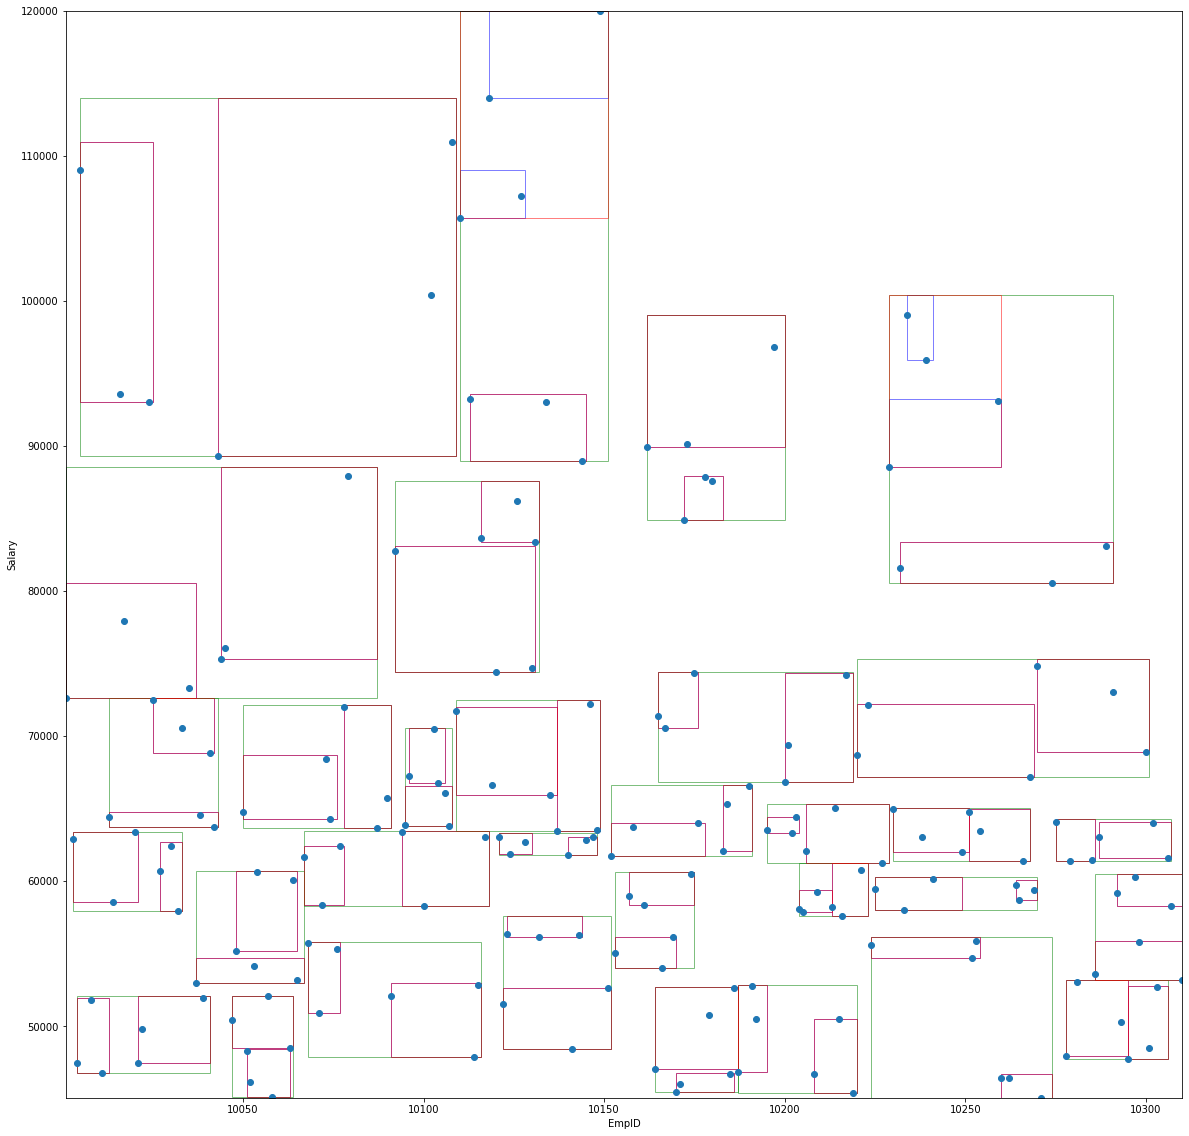

In [17]:
categorical_drop = set(('Employee_Name','Position', 'State', 'Zip', 'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc','TermReason' ,'EmploymentStatus', 'Department', 'ManagerName', 'RecruitmentSource', 'PerformanceScore' ))
df_main.drop('DOB', axis=1, inplace=True)
df_main.drop('LastPerformanceReview_Date',  axis=1, inplace=True)
df_main.drop('DateofTermination', axis=1, inplace=True)
df_main.drop('DateofHire',  axis=1, inplace=True)

indexes = build_indexes(df_main)
column_x, column_y = group_columns[:2]

rects_of_k = get_partition_rects(df_main, k_partitions, column_x, column_y, indexes)
rects_of_l = get_partition_rects(df_main, l_partitions, column_x, column_y, indexes)
rects_of_t = get_partition_rects(df_main, t_partitions, column_x, column_y, indexes)

#Plotting the rectangles on the graph
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)
    
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
plot_rects(df_main, ax, rects_of_l, column_x, column_y, edgecolor='blue')
plot_rects(df_main, ax, rects_of_t, column_x, column_y, edgecolor='green')
plot_rects(df_main, ax, rects_of_k, column_x, column_y, edgecolor='red')


plt.scatter(df_main[column_x], df_main[column_y])
plt.show()

In [18]:


# feats = ["EmpID", "Salary"]
# df_k.sort_values(feats+[sensitive_column])
# # df_k.groupby("RecruitmentSource").size()

df_main[df_main[''] >= 125000]

KeyError: ''

In [ ]:
cats = ["EmpID", "Salary"]
for column in cats:
        error_k = df_main[column]-df_k[column][0]/df_main[column]
        error_l = df_main[column]-df_l[column][0]/df_main[column]
        error_t = df_main[column]-df_t[column][0]/df_main[column]

# error_k.mean()
# error_l.mean()
# error_t.mean()

if (error_k.mean() > error_l.mean()):
        if (error_k.mean() > error_t.mean()):
                print ("k")
        else:
                print ("t")
elif (error_l.mean() > error_t.mean()):
        print ("l")
        